In [1]:
import torch
from torch import optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as tt

from utils import CustomDataSet, load_data, print_config, DeviceDataLoader, supervised_samples, calc_mean_std, plotting, get_PATH, set_random_seed
import config

from Classify import Classifier

In [2]:
print_config()

RANDOM_SEED  :  11042004
DATA_DIR     :    ./data
USED_DATA    :   CIFAR10
NUM_LABELLED :      5000
DEVICE       :    cuda:0
EPOCHS       :        50
BATCH_SIZE   :        64
LEARNING_RATE:      0.01
SCHED        :      True


In [3]:
set_random_seed(config.RANDOM_SEED)

Setting seeds ...... 



In [4]:
name = "CNN"

In [5]:
PATH = get_PATH(name)
PATH

'CIFAR10/CNN5000'

In [6]:
X_train, y_train, X_test, y_test, classes = load_data(0, 1)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
classes


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
n_classes = len(classes)
channels = X_train.shape[1]
n_classes, channels

(10, 3)

In [9]:
X_train, y_train = supervised_samples(X_train, y_train, config.NUM_LABELLED, n_classes)

In [10]:
y_train = y_train.type(torch.ByteTensor)
y_test = y_test.type(torch.ByteTensor)

In [11]:
mean, std = calc_mean_std(X_train)
mean, std

([0.48905855364836753, 0.4813015405541286, 0.44677200361657887],
 [0.24824874103069305, 0.24429000914096832, 0.2621007263660431])

In [12]:
if config.USED_DATA == "CIFAR10":

	train_tfm = tt.Compose([
		tt.RandomCrop(32, padding=4, padding_mode='edge'),
		tt.RandomHorizontalFlip(),
		tt.Normalize(mean, std, inplace=True)
	])

if config.USED_DATA == "MNIST":
	train_tfm = tt.Compose([
		tt.Normalize(mean, std, inplace=True)
	])

valid_tfm = tt.Compose([
	tt.Normalize(mean, std)
])

In [13]:
train_ds = CustomDataSet(X_train, y_train, train_tfm)
valid_ds= CustomDataSet(X_test, y_test, valid_tfm)

In [14]:
def show_image(img, label):
	print("Label: ("+str(label)+")")
	plt.imshow(img.permute(1,2,0))

In [15]:
train_dl = DataLoader(train_ds, config.BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, config.BATCH_SIZE, num_workers=3, pin_memory=True)

In [16]:
def show_batch(dl: DataLoader):
	for images, labels in dl:
		fig,ax= plt.subplots(figsize=(12,12))
		ax.set_xticks([])
		ax.set_yticks([])
		ax.imshow(make_grid(images[:64],nrow=8).permute(1,2,0))
		break # printing only first 64 images from first batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


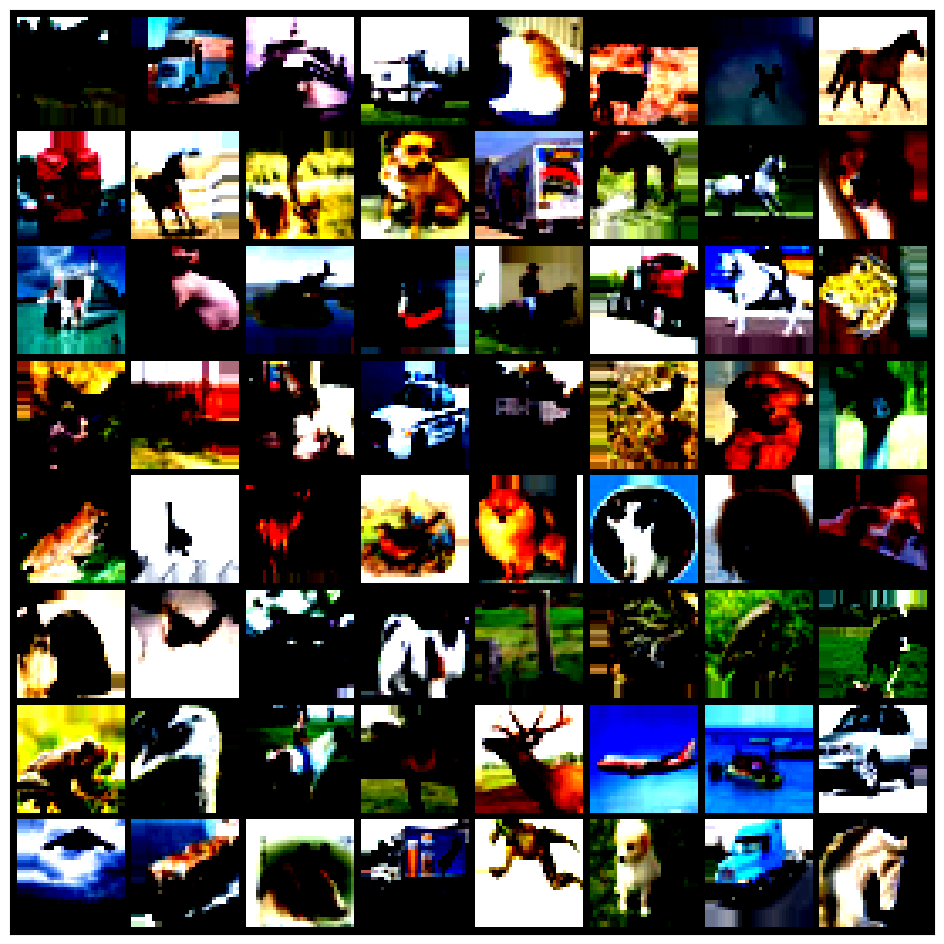

In [17]:
show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


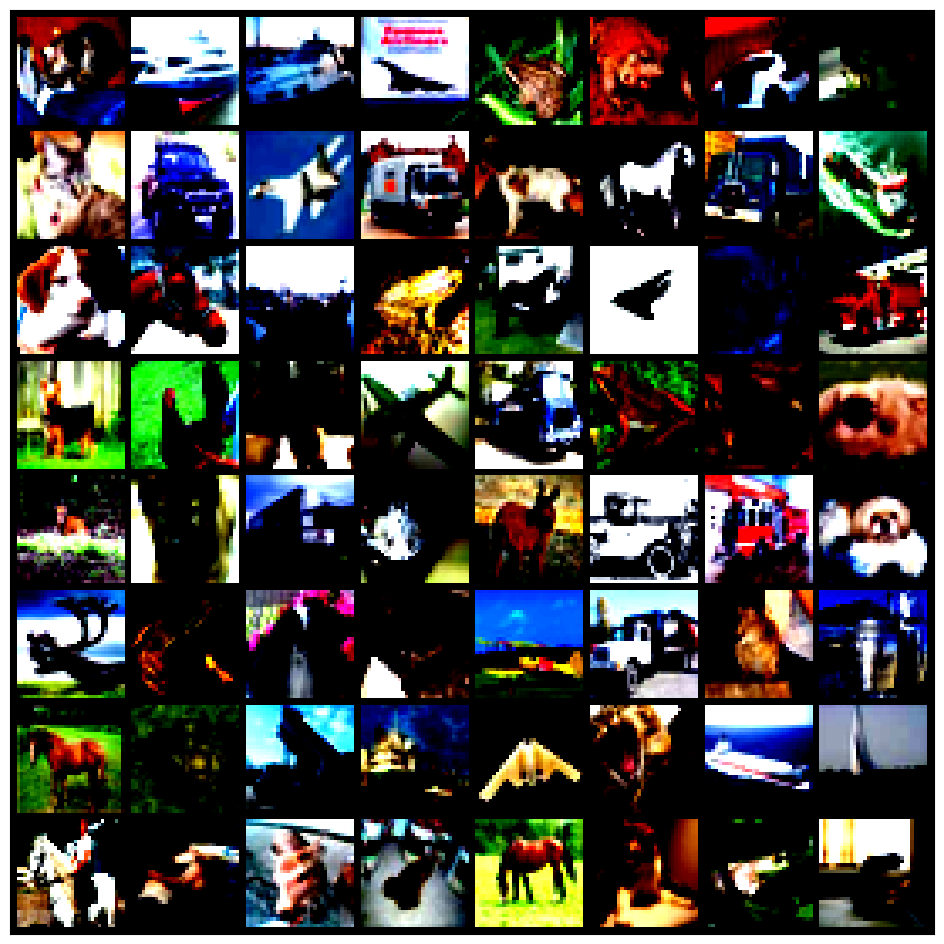

In [18]:
show_batch(valid_dl)

In [19]:
train_dl = DeviceDataLoader(train_dl, config.DEVICE)
valid_dl = DeviceDataLoader(valid_dl, config.DEVICE)

In [20]:
model = Classifier(channels, n_classes).to(config.DEVICE, non_blocking=True)
model

Classifier(
  (conv): ConvModel(
    (conv1): ConvBn(
      (Conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (pool): Identity()
    )
    (conv2): ConvBn(
      (Conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): ConvBn(
      (Conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): ConvBn(
      (Conv): Conv2d(256, 512, kernel_size=(3,

In [21]:
history = model.fit(config.EPOCHS, config.LEARNING_RATE, train_dl, valid_dl, weight_decay=0, grad_clip=None, opt_func=optim.Adam, threshold=0.9925, sched=config.SCHED, PATH=PATH+".pt", save_best=True)

Epoch [0]


100%|██████████| 79/79 [00:02<00:00, 32.67it/s]


train_loss: 1.7542, val_loss: 1.5408, train_acc: 0.3624, val_acc: 0.4568, lrs: 0.0004->0.0005
Epoch [1]


100%|██████████| 79/79 [00:02<00:00, 38.09it/s]


train_loss: 1.4000, val_loss: 1.3798, train_acc: 0.4982, val_acc: 0.5005, lrs: 0.0005->0.0008
Epoch [2]


100%|██████████| 79/79 [00:02<00:00, 38.75it/s]


train_loss: 1.3007, val_loss: 1.5722, train_acc: 0.5458, val_acc: 0.4502, lrs: 0.0008->0.0013
Epoch [3]


100%|██████████| 79/79 [00:02<00:00, 37.78it/s]


train_loss: 1.2268, val_loss: 1.1400, train_acc: 0.5584, val_acc: 0.5950, lrs: 0.0013->0.0020
Epoch [4]


100%|██████████| 79/79 [00:02<00:00, 37.98it/s]


train_loss: 1.1409, val_loss: 1.2847, train_acc: 0.5916, val_acc: 0.5613, lrs: 0.0020->0.0028
Epoch [5]


100%|██████████| 79/79 [00:02<00:00, 38.00it/s]


train_loss: 1.1428, val_loss: 1.2756, train_acc: 0.5988, val_acc: 0.5920, lrs: 0.0028->0.0037
Epoch [6]


100%|██████████| 79/79 [00:02<00:00, 37.66it/s]


train_loss: 1.1227, val_loss: 1.2600, train_acc: 0.6050, val_acc: 0.5754, lrs: 0.0037->0.0047
Epoch [7]


100%|██████████| 79/79 [00:02<00:00, 37.45it/s]


train_loss: 1.2282, val_loss: 1.2372, train_acc: 0.5996, val_acc: 0.5878, lrs: 0.0047->0.0057
Epoch [8]


100%|██████████| 79/79 [00:02<00:00, 37.62it/s]


train_loss: 1.1424, val_loss: 1.3266, train_acc: 0.6122, val_acc: 0.5900, lrs: 0.0057->0.0067
Epoch [9]


100%|██████████| 79/79 [00:02<00:00, 37.50it/s]


train_loss: 0.9726, val_loss: 1.3934, train_acc: 0.6632, val_acc: 0.5772, lrs: 0.0067->0.0076
Epoch [10]


100%|██████████| 79/79 [00:02<00:00, 37.09it/s]


train_loss: 0.9458, val_loss: 1.2881, train_acc: 0.6792, val_acc: 0.5977, lrs: 0.0076->0.0084
Epoch [11]


100%|██████████| 79/79 [00:02<00:00, 36.57it/s]


train_loss: 0.8724, val_loss: 1.7095, train_acc: 0.6992, val_acc: 0.5345, lrs: 0.0084->0.0091
Epoch [12]


100%|██████████| 79/79 [00:02<00:00, 37.04it/s]


train_loss: 0.8382, val_loss: 1.1551, train_acc: 0.7156, val_acc: 0.6294, lrs: 0.0091->0.0096
Epoch [13]


100%|██████████| 79/79 [00:02<00:00, 36.85it/s]


train_loss: 0.7687, val_loss: 1.7764, train_acc: 0.7346, val_acc: 0.5493, lrs: 0.0096->0.0099
Epoch [14]


100%|██████████| 79/79 [00:02<00:00, 37.89it/s]


train_loss: 0.7017, val_loss: 1.0857, train_acc: 0.7608, val_acc: 0.6628, lrs: 0.0099->0.0100
Epoch [15]


100%|██████████| 79/79 [00:02<00:00, 37.37it/s]


train_loss: 0.6322, val_loss: 2.0645, train_acc: 0.7848, val_acc: 0.5034, lrs: 0.0100->0.0100
Epoch [16]


100%|██████████| 79/79 [00:02<00:00, 37.08it/s]


train_loss: 0.6106, val_loss: 1.5181, train_acc: 0.7850, val_acc: 0.5959, lrs: 0.0100->0.0099
Epoch [17]


100%|██████████| 79/79 [00:02<00:00, 37.26it/s]


train_loss: 0.5360, val_loss: 1.0743, train_acc: 0.8114, val_acc: 0.6765, lrs: 0.0099->0.0098
Epoch [18]


100%|██████████| 79/79 [00:02<00:00, 37.25it/s]


train_loss: 0.4202, val_loss: 1.4194, train_acc: 0.8586, val_acc: 0.6360, lrs: 0.0098->0.0097
Epoch [19]


100%|██████████| 79/79 [00:02<00:00, 37.24it/s]


train_loss: 0.4465, val_loss: 0.9305, train_acc: 0.8490, val_acc: 0.7131, lrs: 0.0097->0.0095
Epoch [20]


100%|██████████| 79/79 [00:02<00:00, 37.06it/s]


train_loss: 0.3360, val_loss: 1.3594, train_acc: 0.8872, val_acc: 0.6388, lrs: 0.0095->0.0093
Epoch [21]


100%|██████████| 79/79 [00:02<00:00, 36.29it/s]


train_loss: 0.3842, val_loss: 0.9345, train_acc: 0.8666, val_acc: 0.7212, lrs: 0.0093->0.0090
Epoch [22]


100%|██████████| 79/79 [00:02<00:00, 36.96it/s]


train_loss: 0.3536, val_loss: 0.8069, train_acc: 0.8804, val_acc: 0.7456, lrs: 0.0090->0.0088
Epoch [23]


100%|██████████| 79/79 [00:02<00:00, 37.02it/s]


train_loss: 0.3021, val_loss: 1.2292, train_acc: 0.8964, val_acc: 0.6655, lrs: 0.0088->0.0085
Epoch [24]


100%|██████████| 79/79 [00:02<00:00, 37.26it/s]


train_loss: 0.3137, val_loss: 1.0864, train_acc: 0.8928, val_acc: 0.6979, lrs: 0.0084->0.0081
Epoch [25]


100%|██████████| 79/79 [00:02<00:00, 37.01it/s]


train_loss: 0.2453, val_loss: 0.8687, train_acc: 0.9186, val_acc: 0.7446, lrs: 0.0081->0.0077
Epoch [26]


100%|██████████| 79/79 [00:02<00:00, 36.84it/s]


train_loss: 0.2089, val_loss: 0.8950, train_acc: 0.9314, val_acc: 0.7492, lrs: 0.0077->0.0074
Epoch [27]


100%|██████████| 79/79 [00:02<00:00, 37.04it/s]


train_loss: 0.1992, val_loss: 1.3334, train_acc: 0.9340, val_acc: 0.6682, lrs: 0.0074->0.0070
Epoch [28]


100%|██████████| 79/79 [00:02<00:00, 37.01it/s]


train_loss: 0.1953, val_loss: 0.8546, train_acc: 0.9328, val_acc: 0.7630, lrs: 0.0070->0.0065
Epoch [29]


100%|██████████| 79/79 [00:02<00:00, 36.54it/s]


train_loss: 0.1145, val_loss: 0.8673, train_acc: 0.9652, val_acc: 0.7554, lrs: 0.0065->0.0061
Epoch [30]


100%|██████████| 79/79 [00:02<00:00, 36.53it/s]


train_loss: 0.1221, val_loss: 0.7876, train_acc: 0.9642, val_acc: 0.7763, lrs: 0.0061->0.0057
Epoch [31]


100%|██████████| 79/79 [00:02<00:00, 36.34it/s]


train_loss: 0.1020, val_loss: 0.9070, train_acc: 0.9700, val_acc: 0.7592, lrs: 0.0057->0.0052
Epoch [32]


100%|██████████| 79/79 [00:02<00:00, 36.41it/s]


train_loss: 0.0833, val_loss: 0.8894, train_acc: 0.9772, val_acc: 0.7597, lrs: 0.0052->0.0048
Epoch [33]


100%|██████████| 79/79 [00:02<00:00, 36.83it/s]


train_loss: 0.0938, val_loss: 0.8182, train_acc: 0.9688, val_acc: 0.7725, lrs: 0.0048->0.0043
Epoch [34]


100%|██████████| 79/79 [00:02<00:00, 36.39it/s]


train_loss: 0.0564, val_loss: 0.7969, train_acc: 0.9846, val_acc: 0.7791, lrs: 0.0043->0.0039
Epoch [35]


100%|██████████| 79/79 [00:02<00:00, 36.51it/s]


train_loss: 0.0502, val_loss: 0.7517, train_acc: 0.9896, val_acc: 0.7897, lrs: 0.0039->0.0034
Epoch [36]


100%|██████████| 79/79 [00:02<00:00, 36.70it/s]


train_loss: 0.0538, val_loss: 0.8035, train_acc: 0.9860, val_acc: 0.7801, lrs: 0.0034->0.0030
Epoch [37]


100%|██████████| 79/79 [00:02<00:00, 36.42it/s]


train_loss: 0.0365, val_loss: 0.7552, train_acc: 0.9930, val_acc: 0.7950, lrs: 0.0030->0.0026
Epoch [38]


100%|██████████| 79/79 [00:02<00:00, 36.40it/s]


train_loss: 0.0388, val_loss: 0.7699, train_acc: 0.9910, val_acc: 0.7917, lrs: 0.0026->0.0022
Epoch [39]


100%|██████████| 79/79 [00:02<00:00, 36.27it/s]


train_loss: 0.0238, val_loss: 0.7422, train_acc: 0.9958, val_acc: 0.7976, lrs: 0.0022->0.0019
Epoch [40]


100%|██████████| 79/79 [00:02<00:00, 36.01it/s]


train_loss: 0.0205, val_loss: 0.7403, train_acc: 0.9978, val_acc: 0.7980, lrs: 0.0019->0.0015
Epoch [41]


100%|██████████| 79/79 [00:02<00:00, 36.74it/s]


train_loss: 0.0202, val_loss: 0.7494, train_acc: 0.9966, val_acc: 0.8002, lrs: 0.0015->0.0012
Epoch [42]


100%|██████████| 79/79 [00:02<00:00, 36.31it/s]


train_loss: 0.0160, val_loss: 0.7533, train_acc: 0.9974, val_acc: 0.7996, lrs: 0.0012->0.0010
Epoch [43]


100%|██████████| 79/79 [00:02<00:00, 36.70it/s]


train_loss: 0.0159, val_loss: 0.7301, train_acc: 0.9974, val_acc: 0.8030, lrs: 0.0009->0.0007
Epoch [44]


100%|██████████| 79/79 [00:02<00:00, 36.63it/s]


train_loss: 0.0135, val_loss: 0.7430, train_acc: 0.9982, val_acc: 0.8012, lrs: 0.0007->0.0005
Epoch [45]


100%|██████████| 79/79 [00:02<00:00, 36.59it/s]


train_loss: 0.0148, val_loss: 0.7423, train_acc: 0.9978, val_acc: 0.8008, lrs: 0.0005->0.0003
Epoch [46]


100%|██████████| 79/79 [00:02<00:00, 36.45it/s]


train_loss: 0.0139, val_loss: 0.7408, train_acc: 0.9988, val_acc: 0.8032, lrs: 0.0003->0.0002
Epoch [47]


100%|██████████| 79/79 [00:02<00:00, 36.43it/s]


train_loss: 0.0149, val_loss: 0.7363, train_acc: 0.9990, val_acc: 0.8042, lrs: 0.0002->0.0001
Epoch [48]


100%|██████████| 79/79 [00:02<00:00, 36.43it/s]


train_loss: 0.0151, val_loss: 0.7394, train_acc: 0.9984, val_acc: 0.8023, lrs: 0.0001->0.0000
Epoch [49]


100%|██████████| 79/79 [00:02<00:00, 36.31it/s]


train_loss: 0.0124, val_loss: 0.7434, train_acc: 0.9992, val_acc: 0.8019, lrs: 0.0000->0.0000


In [22]:
model.evaluate(valid_dl)

0.8019000291824341

ship ship


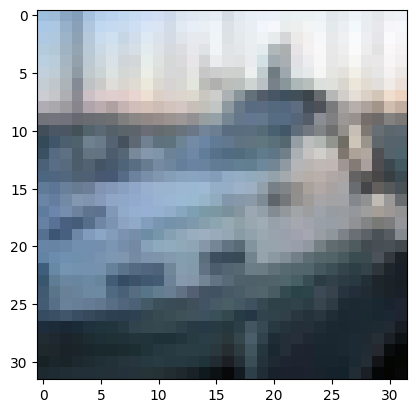

In [28]:
test = 2
out = model(valid_ds[test][0].unsqueeze(0).cuda())
_, pred = torch.max(out, dim=1)

print(classes[pred.item()], classes[y_test[test].item()])

plt.imshow(X_test[test].permute(1, 2, 0))


In [29]:
import pickle

In [30]:
with open(PATH + ".pickle", 'wb') as f:
	pickle.dump(history, f)

In [31]:
with open(PATH + ".pickle", 'rb') as f:
	history = pickle.load(f)

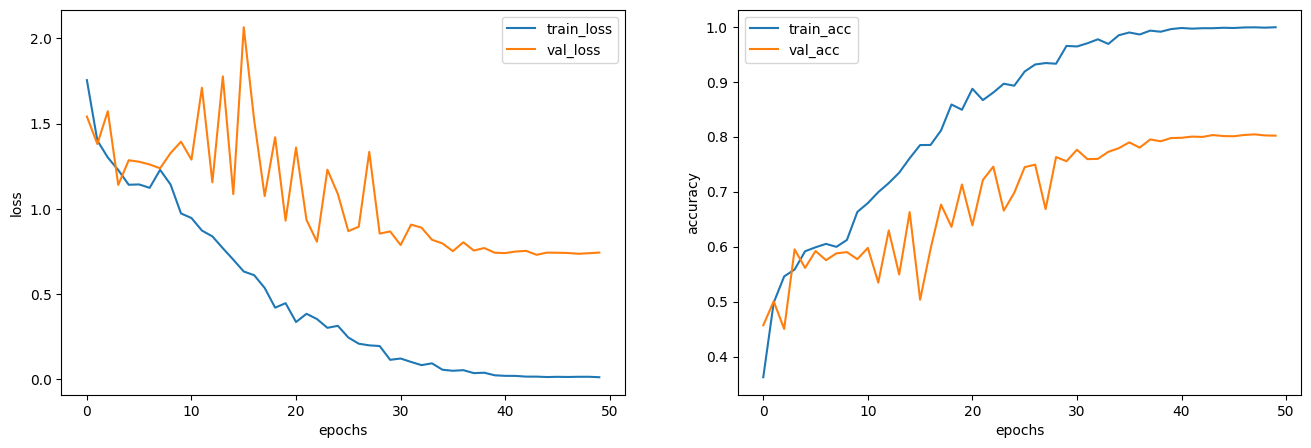

In [32]:
plotting(history, False)